# トラッキング

複数のセンサを用いて、動いている物体の位置を推定する問題をUKFによって解く

K個のセンサーから得られる情報は
1. センサーの位置
2. センサーから測定された物体の角度
である。

動体のシステムモデルは速度がブラウン運動すると仮定し、離散ウィーナ速度モデルを用いた。

![mdk](images/tracking2.jpg)

- システム方程式

    $
      \left[
        \begin{array}{r}
          x_{k} \\
          y_{k} \\
          \dot{x}_{k} \\
          \dot{y}_{k} 
        \end{array}
      \right]
    =
      \left[
        \begin{array}{rrrr}
          1 & 0 & dt & 0 \\
          0 & 1 & 0 & dt \\
          0 & 0 & 1 & 0 \\
          0 & 0 & 0 & 1 \\
        \end{array}
      \right]
      \left[
        \begin{array}{r}
          x_{k-1} \\
          y_{k-1} \\
          \dot{x}_{k-1} \\
          \dot{y}_{k-1} 
        \end{array}
      \right]
      +\mathbf{q}_{k-1}
    $
- 観測方程式

    $
    \mathbf{\theta}_k^{i}=\tan^{-1}{\frac{y_{k}-s_{y}^{1}}{x_{k}-s_{x}^{1}}}+r_{k}
    $

In [1]:
from bayesianfilter import UnscentedKalmanFilter

In [2]:
import numpy as np

In [3]:
np.random.seed(0)
dt = 0.01 # サンプリングレート 100[Hz]

システムモデルパラメータ

In [4]:
A = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

センサー位置

In [5]:
sensor_positions = [[-3, 5],
                    [0, 10],
                    [3, 10],
                    [-1, 3],
                    [3, -5]]

雑音の分散共分散行列

In [6]:
Q = np.array([[dt ** 3 / 3, 0, dt ** 2 / 2, 0],
              [0, dt ** 3 / 3, 0, dt ** 2 / 2],
              [dt ** 2 / 2, 0, dt, 0],
              [0, dt ** 2 / 2, 0, dt]])

R = np.eye(len(sensor_positions))

In [7]:
Q *= 10 ** -1
R *= 10 ** -3

システム方程式

In [8]:
def transition_function(x):
    return A @ x

観測方程式

In [9]:
def observation_function(x):
    observation_list = []
    for sensor_position in sensor_positions:
        theta = np.arctan2(x[1] - sensor_position[1], x[0] - sensor_position[0])
        observation_list.append(theta)

    return np.array(observation_list)

初期状態

In [12]:
state = np.array([0, 0, 0.0, 0.0])

真の軌道生成

In [11]:
true_state_list = []
observation_list = []

In [13]:
for i in range(1000):
    state = np.random.multivariate_normal(transition_function(state), Q)

    observation = np.random.multivariate_normal(observation_function(state), R)

    true_state_list.append(state)
    observation_list.append(observation)

UKFインスタンス生成

In [14]:
ukf = UnscentedKalmanFilter(state_dim=4, observation_dim=len(sensor_positions), transition_function=transition_function,
                            observation_function=observation_function, process_noise=Q, observation_noise=R)

UKFを用いて推定

In [16]:
estimate_list = []
for i, observation in enumerate(observation_list):
    ukf.update(observation)
    estimate_list.append(ukf.state_mean)

In [17]:
for i, observation in enumerate(observation_list):
    ukf.update(observation)
    estimate_list.append(ukf.state_mean)

描画処理

In [18]:
estimate_list = np.array(estimate_list)
import matplotlib.pyplot as plt

In [19]:
%matplotlib inline

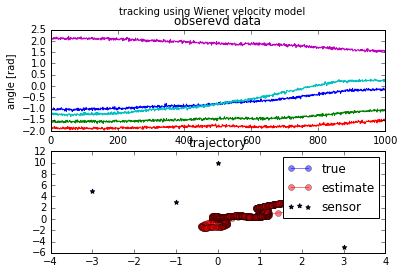

In [20]:
plt.suptitle("tracking using Wiener velocity model")
plt.subplot(211)
plt.title("obserevd data")
plt.plot(observation_list)
plt.ylabel("angle [rad]")
plt.subplot(212)
plt.title("trajectory")
plt.plot(np.array(true_state_list)[:, 0], np.array(true_state_list)[:, 1], "bo-", alpha=0.5, label="true")
plt.plot(estimate_list[:, 0], estimate_list[:, 1], "ro-", alpha=0.5, label="estimate")

plt.scatter(np.array(sensor_positions)[:, 0], np.array(sensor_positions)[:, 1], marker="*", label="sensor")
plt.legend()

凡例が邪魔なので非表示で再プロット

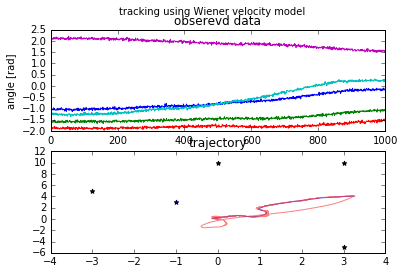

In [21]:
plt.suptitle("tracking using Wiener velocity model")
plt.subplot(211)
plt.title("obserevd data")
plt.plot(observation_list)
plt.ylabel("angle [rad]")
plt.subplot(212)
plt.title("trajectory")
plt.plot(np.array(true_state_list)[:, 0], np.array(true_state_list)[:, 1], "b-", alpha=0.5, label="true")
plt.plot(estimate_list[:, 0], estimate_list[:, 1], "r-", alpha=0.5, label="estimate")

plt.scatter(np.array(sensor_positions)[:, 0], np.array(sensor_positions)[:, 1], marker="*", label="sensor")
